In [1]:
from Bio.Cluster import kcluster
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import shutil
import glob
import time
import os
import re

### Analysis input
input="XBB15-LCB1"
input_dataframe=pd.read_csv(f"output/{input}/opt_binders/filtered_binders.csv")

os.makedirs(f"output/{input}/filtered_sequences/filtered_binders", exist_ok=True)
input_dataframe.describe()

,score,plddt,i_ptm,i_pae,rmsd,ddg,rg,charge,sap,dG,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.826036,0.955420,0.901549,3.943733,0.146916,-51.231841,10.040948,-3.655313,25.629001,67.423314,1650.549033,3.949831,10.810976,6.743902,7.036585,0.678313,-36.422164,-3.106970,-2.221277
std,0.039941,0.000811,0.005787,0.067221,0.051442,2.054586,0.030379,1.058477,5.482801,69.000298,82.246273,4.098190,3.946840,1.592243,0.244955,0.015785,5.087742,0.099030,0.389938
min,0.730676,0.954476,0.888785,3.822869,0.052879,-54.357000,9.960623,-6.800058,17.582819,-23.196578,1231.566345,-1.519539,3.000000,1.000000,7.000000,0.637880,-49.238138,-3.672559,-3.140232
25%,0.798263,0.954810,0.895682,3.910507,0.110071,-52.964750,10.014651,-4.757677,20.690872,-3.988860,1591.412872,-0.246005,8.000000,5.000000,7.000000,0.668589,-39.770990,-3.126144,-2.497758
50%,0.824682,0.955170,0.904840,3.944346,0.139946,-52.199500,10.031329,-3.701676,23.650586,78.631304,1696.164010,4.596325,12.000000,7.000000,7.000000,0.676787,-35.319272,-3.089311,-2.088624
75%,0.855757,0.955790,0.906909,3.966463,0.178190,-49.412000,10.072030,-2.767276,30.991885,116.188504,1716.538268,6.771054,14.000000,8.000000,7.000000,0.683489,-32.830431,-3.050420,-1.926683
max,0.950638,0.957900,0.911125,4.429562,0.341782,-45.230000,10.089997,-2.682179,36.945316,304.327951,1745.231987,18.433581,19.000000,9.000000,9.000000,0.726146,-23.811998,-3.000509,-1.396189


In [ ]:
# Functions
# add scaffold name column
def add_scaffold_name_column(filtered, prefix):
    filtered["scaffold_name"] = ""
    
    for index, row in filtered.iterrows():
        path = row["model_path"]
        prefix = prefix
        file_name = path.split("/")[-1]
        parts = file_name.split(prefix)[-1].split("_")
        
        if len(parts) >= 5:
            result = f"{parts[0]}_{parts[1]}"
        else:
            result = parts[0].split(".")[0]
        
        filtered.at[index, "scaffold_name"] = result
    
    return filtered

def repeat_rows_by_column_value(df, column_name, number):
    unique_values = df[column_name].unique()
    repeated_rows = []

    for value in unique_values:
        subset = df[df[column_name] == value]
        num_repeats = min(number, subset.shape[0])
        repeated_rows.extend([subset.iloc[i, :] for i in range(num_repeats)])

    repeated_df = pd.DataFrame(repeated_rows)
    return repeated_df


## Filter dataframe
tipical metrics:
- plddt > 0.85-0.9
- i_pae < 5
- ddg_dsasa_100 < -2.5 - -3.5 (sort by)
additional metrics:
- charge < -2
- hyd_contacts > 4-6
- sap < 30-60

In [3]:
filtered = input_dataframe[(input_dataframe["plddt"]>0.90)&
                           (input_dataframe["ddg"]<-30)&
                           (input_dataframe["charge"]<-2)&
                           (input_dataframe["ddg_dsasa_100"]<-2.5)&
                           #(input_dataframe["ddgscore_dsasa_100"]<-2.5)&
                           (input_dataframe["shape_comp"]>0.62)&
                           (input_dataframe["hyd_contacts"]>6)&
                           (input_dataframe["sap"]<40)]#&
                           #(input_dataframe["dG"]<30)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv", index=False)
filtered

,score,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,ddg,rg,charge,...,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,seq
0,0.766746,0.955639,0.888785,4.376522,0.199316,output/XBB15-LCB1/opt_binders/binders/579_470/...,output/XBB15-LCB1/opt_binders/binders/579_470/...,-45.230,10.023927,-2.716361,...,1231.566345,1.525011,10.0,1.0,9.0,0.707727,-36.598774,-3.672559,-2.971726,SPFARAVEIHRRAMELYKEGKKEEANKVFELLREWAKTKDESLLDE...
1,0.785096,0.954575,0.889905,4.429562,0.216167,output/XBB15-LCB1/opt_binders/binders/579_470/...,output/XBB15-LCB1/opt_binders/binders/579_470/...,-46.007,10.036078,-3.717047,...,1258.483147,0.203190,11.0,1.0,9.0,0.726146,-36.819847,-3.655750,-2.925732,SPFARAVEIHKRAMELYKKGKKEEAEKVFELLREWAKTKNEELLDE...
2,0.812374,0.954649,0.894636,4.008572,0.086369,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-52.574,10.067076,-4.762486,...,1540.575276,-0.521886,5.0,8.0,7.0,0.676264,-42.909874,-3.412621,-2.785315,SSLDRLNKIVAEAKELETLGKFEESLEVYDLIGKYLNTKDEKYLDE...
3,0.745213,0.955274,0.895376,3.957288,0.104024,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.186,10.077020,-2.772061,...,1515.589685,-0.729657,4.0,9.0,7.0,0.681681,-43.755070,-3.377299,-2.887000,SDLDRLNKIVKEAKELETLGKYEESLEVYDLIGKYLNTKDKKYLDE...
4,0.795052,0.955477,0.895440,3.992614,0.106472,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.736,10.078912,-2.768882,...,1546.347072,-1.320101,4.0,9.0,7.0,0.670714,-45.126033,-3.345691,-2.918234,SDLERLNKIVKEAKELETLGKFEESLEVYDLIGKYLNTKDKKYLDE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.797686,0.955196,0.895754,3.965950,0.086379,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-47.658,10.077405,-4.769109,...,1585.979148,-0.494048,4.0,9.0,7.0,0.702933,-46.986712,-3.004958,-2.962631,SDLDRLNKIVKEAEELKTLGKYEESLDVYDLIGEYLNTKDKKYLDE...
160,0.826284,0.954879,0.899444,3.875973,0.211538,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.283,10.034939,-3.755176,...,1607.590893,1.195900,18.0,5.0,7.0,0.675635,-40.154567,-3.003438,-2.497810,SSLERANRLVAEADALAAEGKFEAALDIKELVGLYFNTKDESYLKQ...
161,0.876326,0.955508,0.896881,3.956453,0.341782,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.452,10.056201,-3.762511,...,1614.080291,0.655237,15.0,5.0,7.0,0.668648,-33.356205,-3.001833,-2.066577,SNLDRANRLVEEADKLEKQGKWEEALDIKELVGLYYNTKDESYLTK...
162,0.769324,0.955102,0.895309,3.941662,0.231736,output/XBB15-LCB1/opt_binders/binders/976_304/...,output/XBB15-LCB1/opt_binders/binders/976_304/...,-48.580,10.078514,-4.767061,...,1618.360753,0.130637,10.0,5.0,7.0,0.658425,-36.048491,-3.001803,-2.227469,SDLDKANELVKEAEELEKEGKYEEALEIKELVGLYFNTKDKSYLTK...


In [ ]:
filtered=add_scaffold_name_column(filtered, input+"_")
filtered

In [ ]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)

## Test with ColabFold and Rosettafold2

In [4]:
def generate_fasta_sequence_from_pdb(pdb_file, output_folder=None):
    ca_pattern = re.compile("^ATOM\s{2,6}\d{1,5}\s{2}CA\s[\sA]([A-Z]{3})\s([\s\w])|^HETATM\s{0,4}\d{1,5}\s{2}CA\s[\sA](MSE)\s([\s\w])")
    aa3to1={
        'ALA':'A', 'VAL':'V', 'PHE':'F', 'PRO':'P', 'MET':'M',
        'ILE':'I', 'LEU':'L', 'ASP':'D', 'GLU':'E', 'LYS':'K',
        'ARG':'R', 'SER':'S', 'THR':'T', 'TYR':'Y', 'HIS':'H',
        'CYS':'C', 'ASN':'N', 'GLN':'Q', 'TRP':'W', 'GLY':'G',
        'MSE':'M',
    }
    filename = os.path.basename(pdb_file).split('.')[0]
    chain_dict = dict()
    chain_list = []

    with open(pdb_file, 'r') as fp:
        for line in fp:
            if line.startswith("ENDMDL"):
                break
            match_list = ca_pattern.findall(line)
            if match_list:
                resn = match_list[0][0] + match_list[0][2]
                chain = match_list[0][1] + match_list[0][3]
                if chain in chain_dict:
                    chain_dict[chain] += aa3to1[resn]
                else:
                    chain_dict[chain] = aa3to1[resn]
                    chain_list.append(chain)

    fasta_sequence = f">{filename}\n"
    for i, chain in enumerate(chain_list):
        fasta_sequence += chain_dict[chain]
        if i < len(chain_list) - 1:
            fasta_sequence += ':'

    if output_folder:
        output_file = os.path.join(output_folder, f"{filename}.fasta")
        with open(output_file, 'w') as fp:
            fp.write(fasta_sequence)

    return chain_dict

def process_a3m_file_rf2(binder_sequence, sample_a3m_path, processed_file_name):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        old_binder_sequence = lines[1].strip().split('/')[1]
        for i in range(0, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

            # Check if the line contains "-" and replace it accordingly
            if not lines[i].startswith('>') and lines[i].split('/')[1].startswith("-"):
                lines[i] = lines[i].split('/')[0] + "/" + "-" * len(binder_sequence) + "\n"

        # Save the processed lines to a new file
        new_file_path = f"{processed_file_name}"
        with open(new_file_path, 'w') as new_file:
            new_file.writelines(lines)

def process_a3m_file_af2(binder_sequence, sample_a3m_path, processed_file_name):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Extract the target sequence from the first line
        target_sequence_line = lines[0].strip()
        if target_sequence_line.startswith('#'):
            target_length = int(target_sequence_line[1:].split(',')[0].strip())
            #print(target_length)
        else:
            raise ValueError("The target sequence is not properly specified in the first line.")

        # Change line 0
        lines[0] = f"#{target_length},{len(binder_sequence)}\t1,1\n"
        # Change line 3
        target_sequence = lines[2].strip()[:target_length]
        old_binder_sequence = lines[2].strip()[target_length:]
        lines[2] = target_sequence + binder_sequence + "\n"

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        for i in range(3, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

        # Write the processed lines to the output file
        with open(processed_file_name, 'w') as processed_file:
            processed_file.writelines(lines)

### Generate RF2 MSA files

In [5]:
### Generate MSA from 1 example for RF2

# Create folder for msa files
msa_folder_rf2 = f"output/{input}/filtered_sequences/msa_inputs_rf2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder = f"{msa_folder_rf2}/sample"
os.makedirs(sample_msa_folder, exist_ok=True)
input_pdb=filtered["model_path"][0]
slurm_args="" #"--output=/dev/null"
cmd = f"sbatch {slurm_args} helper_scripts/get_msa_rf.sh {input_pdb} {sample_msa_folder}"

# Run the system command to execute the get_msa.py script
sample_a3m_path = f"{sample_msa_folder}/sample.a3m"
if not os.path.exists(sample_a3m_path):
    os.system(cmd)

# Wait until MSA is calculated...
while not os.path.exists(sample_a3m_path):
    time.sleep(1)
print("MSA calculation is complete.")

MSA calculation is complete.


In [6]:
### Generate other MSA files for RF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_rf2"]=None

filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders"
os.makedirs(filtered_binders_path, exist_ok=True)

binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    shutil.copyfile(model_path, new_model_path)

    # Generate msa
    binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    a3m_file_name=f"{msa_folder_rf2}/{model_name.split('.')[0]}.a3m"
    process_a3m_file_rf2(binder_seq, sample_a3m_path, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_rf2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_rf2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted!")

There is 164 a3m files ready to be predicted!


### Generate MSA for AF2

In [7]:
### Generate MSA from 1 example for AF2

# Create folder for msa files
msa_folder_af2 = f"output/{input}/filtered_sequences/msa_inputs_af2"
os.makedirs(msa_folder_af2, exist_ok=True)

sample_msa_folder = f"{msa_folder_af2}/sample"
os.makedirs(sample_msa_folder, exist_ok=True)
input_pdb=filtered["model_path"][0]
slurm_args="" #"--output=/dev/null"
cmd = f"sbatch {slurm_args} helper_scripts/get_msa_colabfold.sh {input_pdb} {sample_msa_folder}"

# Run the system command to execute the get_msa.py script
sample_a3m_path_af2 = f"{sample_msa_folder}/{input_pdb.split('/')[-1].split('.')[0]}.a3m"
if not os.path.exists(sample_a3m_path_af2):
    os.system(cmd)

# Wait until MSA is calculated...
while not os.path.exists(sample_a3m_path_af2):
    time.sleep(1)
print("MSA calculation is complete.")

MSA calculation is complete.


In [8]:
### Generate other MSA files for AF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_af2"]=None

filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders"
os.makedirs(filtered_binders_path, exist_ok=True)

binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    shutil.copyfile(model_path, new_model_path)

    # Generate msa
    binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    a3m_file_name=f"{msa_folder_af2}/{model_name.split('.')[0]}.a3m"
    process_a3m_file_af2(binder_seq, sample_a3m_path_af2, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_af2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_af2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with AF2!")

There is 165 a3m files ready to be predicted with AF2!


### Run prediction

In [10]:
# Set the prediction options as a dictionary with booleans
prediction_options = {
    "colabfold": True,       # Set to True if you want to run ColabFold
    "rosettafold2": True,    # Set to True if you want to run RosettaFold2 (not currently used)
    "esmfold": False,        # Set to True if you want to run ESMfold (not currently used)
}

array_limit=40
binder_analysis="binder-second" # if you want to perform binder analysis
msa_folder=f"output/{input}/filtered_sequences"

array_number=len(msa_a3m_inputs)
tools = " ".join([tool for tool, should_run in prediction_options.items() if should_run])
print(tools)
bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
script_arguments=f"{msa_folder} {filtered_binders_path} {binder_analysis} {tools} "

command = f"sbatch {bash_arguments} helper_scripts/predict_binders.sh {script_arguments}"
print(command)

colabfold rosettafold2
sbatch --output=/dev/null --array=0-165%40 helper_scripts/predict_binders.sh output/XBB15-LCB1/filtered_sequences output/XBB15-LCB1/filtered_sequences/filtered_binders binder-second colabfold rosettafold2 


In [11]:
subprocess.run(command, shell=True)

Submitted batch job 208462


CompletedProcess(args='sbatch --output=/dev/null --array=0-165%40 helper_scripts/predict_binders.sh output/XBB15-LCB1/filtered_sequences output/XBB15-LCB1/filtered_sequences/filtered_binders binder-second colabfold rosettafold2 ', returncode=0)

### Append and filter with scores

In [9]:
#af2_dataframe_columns = ['plddt', 'pae', 'binder_plddt', 'target_plddt', 'pae_binder', 'pae_target', 'pae_int_tot', 'rmsd', 'name', 'model_id']
#rf2_dataframe_columns = ['mean_plddt', 'pae_chain0_0', 'rmsd', 'name', 'model_id', 'plddt_target', 'plddt_binder', 'plddt', 'pae']

# Open filtered dataframe
filtered = pd.read_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv")
filtered["model_id"]=filtered["model_path"].str.split("/").str[-1].str.split(".").str[0]

# Open scores to append
af2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_af2.csv")
rf2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_rf2.csv")
# Fix old model_ids
af2_scores["model_id"] = af2_scores["model_id"].str.replace(r"-AF2$", "", regex=True)
rf2_scores["model_id"] = rf2_scores["model_id"].str.replace(r"-RF2$", "", regex=True)

# Columns to append
af2_column_append = ['binder_plddt', 'pae_int_tot', 'rmsd']
rf2_column_append = ['plddt_binder', 'pae', 'rmsd']

# Prepare columns to add
rf2_scores = rf2_scores[rf2_column_append + ['model_id']].rename(columns=lambda x: f'rf_{x}' if x != 'model_id' else x)
af2_scores = af2_scores[af2_column_append + ['model_id']].rename(columns=lambda x: f'af_{x}' if x != 'model_id' else x)

# Merge to filtered
filtered = filtered.merge(af2_scores, on='model_id', how='left')
filtered = filtered.merge(rf2_scores, on='model_id', how='left')
filtered.describe()

,score,plddt,i_ptm,i_pae,rmsd,ddg,rg,charge,sap,dG,...,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,af_binder_plddt,af_pae_int_tot,af_rmsd,rf_plddt_binder,rf_pae,rf_rmsd
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,...,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,157.000000,157.000000,157.000000
mean,0.826036,0.955420,0.901549,3.943733,0.146916,-51.231841,10.040948,-3.655313,25.629001,67.423314,...,0.678313,-36.422164,-3.106970,-2.221277,83.351850,8.876867,1.851228,79.656331,13.512447,2.323257
std,0.039941,0.000811,0.005787,0.067221,0.051442,2.054586,0.030379,1.058477,5.482801,69.000298,...,0.015785,5.087742,0.099030,0.389938,7.161468,2.026265,1.097213,1.672572,0.280843,0.676433
min,0.730676,0.954476,0.888785,3.822869,0.052879,-54.357000,9.960623,-6.800058,17.582819,-23.196578,...,0.637880,-49.238138,-3.672559,-3.140232,69.936856,5.646657,0.547194,75.981873,12.992268,1.422085
25%,0.798263,0.954810,0.895682,3.910507,0.110071,-52.964750,10.014651,-4.757677,20.690872,-3.988860,...,0.668589,-39.770990,-3.126144,-2.497758,78.343802,6.938441,0.695253,77.918862,13.306096,2.034043
50%,0.824682,0.955170,0.904840,3.944346,0.139946,-52.199500,10.031329,-3.701676,23.650586,78.631304,...,0.676787,-35.319272,-3.089311,-2.088624,81.785593,8.973705,1.877918,80.275777,13.475245,2.293918
75%,0.855757,0.955790,0.906909,3.966463,0.178190,-49.412000,10.072030,-2.767276,30.991885,116.188504,...,0.683489,-32.830431,-3.050420,-1.926683,91.061791,10.838270,2.624398,81.028907,13.703831,2.363700
max,0.950638,0.957900,0.911125,4.429562,0.341782,-45.230000,10.089997,-2.682179,36.945316,304.327951,...,0.726146,-23.811998,-3.000509,-1.396189,93.280670,12.784464,4.162226,81.698836,14.149649,5.088211


### Filter sequences

In [15]:
filtered = filtered[(filtered["af_binder_plddt"]>80)&
                    (filtered["af_pae_int_tot"]<7)&
                    (filtered["af_rmsd"]<2)&

                    #(filtered["rf_plddt_binder"]>78)&
                    #(filtered["rf_pae"]<15)&
                    (filtered["rf_rmsd"]<22)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/1_filtered_binders.csv", index=False)
filtered

,score,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,ddg,rg,charge,...,ddg_dsasa_100,ddgscore_dsasa_100,seq,model_id,af_binder_plddt,af_pae_int_tot,af_rmsd,rf_plddt_binder,rf_pae,rf_rmsd
2,0.812374,0.954649,0.894636,4.008572,0.086369,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-52.574,10.067076,-4.762486,...,-3.412621,-2.785315,SSLDRLNKIVAEAKELETLGKFEESLEVYDLIGKYLNTKDEKYLDE...,740_279_12_8_12,91.246804,6.392510,0.581449,81.668875,13.122474,1.577860
3,0.745213,0.955274,0.895376,3.957288,0.104024,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.186,10.077020,-2.772061,...,-3.377299,-2.887000,SDLDRLNKIVKEAKELETLGKYEESLEVYDLIGKYLNTKDKKYLDE...,740_279_27_23_12,91.179021,6.999216,0.727416,80.555534,13.371153,1.654342
4,0.795052,0.955477,0.895440,3.992614,0.106472,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.736,10.078912,-2.768882,...,-3.345691,-2.918234,SDLERLNKIVKEAKELETLGKFEESLEVYDLIGKYLNTKDKKYLDE...,740_279_16_18_15,91.475309,6.568594,0.636689,81.224929,13.201643,4.357455
5,0.776767,0.955358,0.893687,3.973718,0.157872,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.554,10.075408,-2.770677,...,-3.344755,-2.809183,SDLDRLNKIVAEAKELETLGKYEESLEVYDLIGQYLNTKDKKYLDK...,740_279_27_12_5,91.718041,6.205688,0.647709,80.314503,13.191396,1.643215
7,0.759609,0.954855,0.894260,3.989875,0.134344,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-50.825,10.081836,-2.771387,...,-3.309676,-2.537907,SDLDRLNKIVEEAKELETLGKYEESLEVYDLIGKYLNTKDKKYLEE...,740_279_24_26_19,91.149845,6.884552,0.631308,80.559928,13.336844,3.039305
8,0.839386,0.955198,0.894691,4.016257,0.178766,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-50.516,10.068017,-4.766376,...,-3.309154,-2.396068,SDLERLNKIVEEAKELVTLGKYEESLEVYDLIGKYLNTKDPKYLDE...,740_279_21_21_7,91.516340,6.937916,0.646152,81.007366,13.138369,3.737065
9,0.807682,0.954588,0.894119,4.059852,0.140378,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-51.523,10.074680,-5.763870,...,-3.305064,-3.006898,SDLERLNKIVEEAKELETLGKYEESLEVYDLIGNYLNTKDKTYLDK...,740_279_6_0_2,91.110670,6.845396,0.547194,80.333707,13.141070,3.006165
10,0.779071,0.955203,0.894963,3.995961,0.092760,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-50.306,10.074537,-4.765255,...,-3.296892,-2.009851,SDLERLNKIVEEAKELETLGKFEESLDVYDLIGKYLNTKDKKYLEE...,740_279_26_1_10,91.087216,6.897648,0.664728,81.229353,13.014983,2.953286
12,0.858699,0.954814,0.895680,3.993222,0.221613,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-49.507,10.082223,-4.765665,...,-3.249333,-2.761366,SDLDRLNEIVKQAQELETLGKYEESLDVYDLIGNYLNTKDKEYLTK...,740_279_16_21_11,91.249021,6.923043,0.694162,80.077908,13.130726,1.665235
15,0.808190,0.956620,0.896178,3.920224,0.116963,output/XBB15-LCB1/opt_binders/binders/740_279/...,output/XBB15-LCB1/opt_binders/binders/740_279/...,-49.837,10.065196,-5.811440,...,-3.192238,-2.612052,TDLDRLNKIVEEAKELETLGKYEESLDVYDLIGNYLNTKDKKYLDE...,740_279_26_2_19,90.988196,6.110157,1.429321,79.849698,13.344113,3.780274


# Cluster sequences

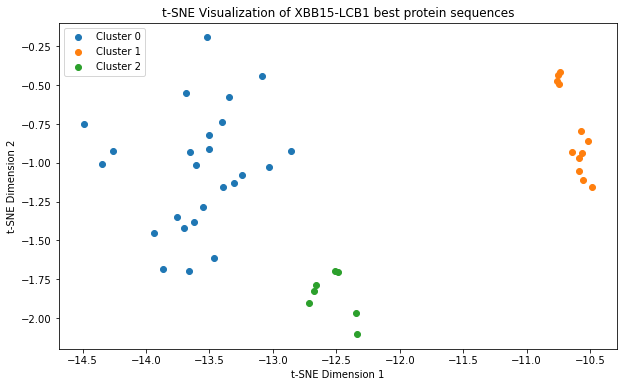

Cluster 0: 25 sequences
Cluster 1: 12 sequences
Cluster 2: 7 sequences


,score,plddt,i_ptm,i_pae,rmsd,ddg,rg,charge,sap,dG,...,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,af_binder_plddt,af_pae_int_tot,af_rmsd,rf_plddt_binder,rf_pae,rf_rmsd
clusterid,,,,,,,,,,,,,,,,,,,,,
0,0.793605,0.955465,0.895088,3.977066,0.131083,-49.403640,10.076952,-3.970287,32.491317,-11.929526,...,0.694847,-42.210568,-3.162528,-2.700601,91.640480,6.558754,0.770224,80.318982,13.185411,2.717937
1,0.814328,0.955310,0.897841,3.888710,0.171074,-49.525500,10.070087,-4.179299,29.535737,59.904550,...,0.667370,-39.774381,-3.067117,-2.464654,91.487101,6.261322,0.731082,80.796544,13.449648,1.773569
2,0.801290,0.954984,0.894699,3.998756,0.116277,-50.019286,10.074098,-4.051861,33.731214,-12.691680,...,0.689529,-38.528784,-3.232997,-2.490582,91.736848,6.421901,0.633162,81.114077,13.171687,2.880008


In [17]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=4

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

cluster_counts = Counter(filtered['clusterid'])

# Group the DataFrame by 'clusterid' and get unique scaffold names for each group
unique_scaffold_names = filtered.groupby('clusterid')['scaffold_name'].unique()

# Iterate over the groups and print both cluster counts and unique scaffold names
for cluster_id, scaffold_names in unique_scaffold_names.items():
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} sequences")
    print(f'Scaffold Names: {", ".join(scaffold_names)}')

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

# Output final dataframe and binders
Code below will create folders with best [12, 24, 48 ..] binders and metrics.
Make sure to change cluster ratios based on the results above!

In [20]:
# Select number of final sequences and cluster ratios
total_numbers=[12, 24, 48, 96, 192]
cluster_ratios = [0.5, 0.25, 0.25]

# Function to calculate the number of sequences for each cluster based on the given ratios
def calculate_sequences_ratios(total_sequences, cluster_ratios):
    cluster_sequences = {}
    total_ratio = sum(cluster_ratios)
    remaining_sequences = total_sequences

    for i, ratio in enumerate(cluster_ratios):
        if i == len(cluster_ratios) - 1:
            cluster_sequences[i] = remaining_sequences
        else:
            sequences_for_cluster = int(total_sequences * ratio / total_ratio)
            cluster_sequences[i] = sequences_for_cluster
            remaining_sequences -= sequences_for_cluster

    return cluster_sequences

In [21]:

for total_sequences in total_numbers:
    # Calculate the number of sequences for each cluster
    cluster_sequences = calculate_sequences_ratios(total_sequences, cluster_ratios)
    print(f"Total Sequences: {total_sequences}")
    print(cluster_sequences)

    # Create a new dataframe with the final number of sequences for each cluster
    final_sequences = []
    for cluster_id, num_sequences in cluster_sequences.items():
        cluster_data = filtered[filtered['clusterid'] == cluster_id].iloc[:num_sequences]
        final_sequences.append(cluster_data)

    final_dataframe = pd.concat(final_sequences)

    # Save the dataframe to a CSV file
    binder_pdbs_path=f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]
        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
            #print(f"Copied {pdb_filename} to {destination_path}")
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Total Sequences: 12
{0: 6, 1: 3, 2: 3}
DataFrame for 12 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_12/final_binders_12.csv
Total Sequences: 24
{0: 12, 1: 6, 2: 6}
DataFrame for 24 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_24/final_binders_24.csv
Total Sequences: 48
{0: 24, 1: 12, 2: 12}
DataFrame for 48 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_48/final_binders_48.csv
Total Sequences: 96
{0: 48, 1: 24, 2: 24}
DataFrame for 96 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_96/final_binders_96.csv
Total Sequences: 192
{0: 96, 1: 48, 2: 48}
DataFrame for 192 sequences saved to output/XBB15-LCB1/filtered_sequences/final_results/binders_192/final_binders_192.csv
